Apriori Algorithm:

The apriori algorithm is an algorithm for mining frequent itemset for boolean association rules.'

Apriori uses a "botton up" approach, where frequent subsets are extended one item at a time which is known as candidate generation, and groups of candidates are tested against the data.

Apriori algorithm is a data mining techniques which helps us mine basket data or data about transaction for association rule.
Basket has 2 meaning:
1.Single transaction: All items brought in one single transaction. 
2.Items brought by user for short period of time like for 1 or 2 month

When a set of basket is fed into Apriori algorithm it will generate set of rules which tells what kind of products are purchased in same basket. Each of these rules has to satisfy minimum support and confidence.

Support and confidence is matrixes that are defined in a way that says how valid a rule is and how strong the association is. Support tells us how many out of all the transaction contain the items in the rule. Confidence tells us how many of the transactions out of all the transaction which contains those items exhibit  these association


#Data Setup
https://github.com/marshallshen/nyc_restaurants_inspection

In [7]:
import pandas as pd

df = pd.read_csv("tesco_dataset.csv")

#df1 = pd.read_csv("Restaurant-Dataset.csv")
df

,apple,beer,rice,chicken
0,apple,beer,rice,NaN
1,apple,beer,NaN,NaN
2,apple,mango,NaN,NaN
3,milk,beer,rice,chicken
4,milk,beer,rice,NaN
5,milk,beer,NaN,NaN
6,milk,mango,NaN,NaN


In [ ]:
# %load apriori.py

import sys

from itertools import chain, combinations
from collections import defaultdict
from optparse import OptionParser
import numpy as np
import matplotlib.pyplot as plt
from numpy import *


def subsets(arr):
    """ Returns non empty subsets of arr"""
    return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])


def returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet):
        """calculates the support for items in the itemSet and returns a subset
       of the itemSet each of whose elements satisfies the minimum support"""
        _itemSet = set()
        localSet = defaultdict(int)

        for item in itemSet:
                for transaction in transactionList:
                        if item.issubset(transaction):
                                freqSet[item] += 1
                                localSet[item] += 1

        for item, count in localSet.items():
                support = float(count)/len(transactionList)

                if support >= minSupport:
                        _itemSet.add(item)

        return _itemSet


def joinSet(itemSet, length):
        """Join a set with itself and returns the n-element itemsets"""
        return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])


def getItemSetTransactionList(data_iterator):
    transactionList = list()
    itemSet = set()
    for record in data_iterator:
        transaction = frozenset(record)
        transactionList.append(transaction)
        for item in transaction:
            itemSet.add(frozenset([item]))              # Generate 1-itemSets
    return itemSet, transactionList


def runApriori(data_iter, minSupport, minConfidence):
    """
    run the apriori algorithm. data_iter is a record iterator
    Return both:
     - items (tuple, support)
     - rules ((pretuple, posttuple), confidence)
    """
    itemSet, transactionList = getItemSetTransactionList(data_iter)

    freqSet = defaultdict(int)
    largeSet = dict()
    # Global dictionary which stores (key=n-itemSets,value=support)
    # which satisfy minSupport

    assocRules = dict()
    # Dictionary which stores Association Rules

    oneCSet = returnItemsWithMinSupport(itemSet,
                                        transactionList,
                                        minSupport,
                                        freqSet)

    currentLSet = oneCSet
    k = 2
    while(currentLSet != set([])):
        largeSet[k-1] = currentLSet
        currentLSet = joinSet(currentLSet, k)
        currentCSet = returnItemsWithMinSupport(currentLSet,
                                                transactionList,
                                                minSupport,
                                                freqSet)
        currentLSet = currentCSet
        k = k + 1

    def getSupport(item):
            """local function which Returns the support of an item"""
            return float(freqSet[item])/len(transactionList)

    toRetItems = []
    for key, value in largeSet.items():
        toRetItems.extend([(tuple(item), getSupport(item))
                           for item in value])

    toRetRules = []
    for key, value in largeSet.items()[1:]:
        for item in value:
            _subsets = map(frozenset, [x for x in subsets(item)])
            for element in _subsets:
                remain = item.difference(element)
                if len(remain) > 0:
                    confidence = getSupport(item)/getSupport(element)
                    if confidence >= minConfidence:
                        toRetRules.append(((tuple(element), tuple(remain)),
                                           confidence))
    return toRetItems, toRetRules


def printResults(items, rules):
    """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
    for item, support in sorted(items, key=lambda (item, support): support):
        print "item: %s , %.3f" % (str(item), support)
    print "\n------------------------ RULES:"
    for rule, confidence in sorted(rules, key=lambda (rule, confidence): confidence):
        pre, post = rule
        print "Rule: %s  ==> %s , %.3f" % (str(pre), str(post), confidence)


def dataFromFile(fname):
        """Function which reads from the file and yields a generator"""
        file_iter = open(fname, 'rU')
        for line in file_iter:
                line = line.strip().rstrip(',')                         # Remove trailing comma
                record = frozenset(line.split(','))
                yield record


if __name__ == "__main__":

    optparser = OptionParser()
    optparser.add_option('-f', '--inputFile',
                         dest='input',
                         help='filename containing csv',
                         default=None)
    optparser.add_option('-s', '--minSupport',
                         dest='minS',
                         help='minimum support value',
                         default=0.15,
                         type='float')
    optparser.add_option('-c', '--minConfidence',
                         dest='minC',
                         help='minimum confidence value',
                         default=0.6,
                         type='float')

    (options, args) = optparser.parse_args()

    inFile = None
    if options.input is None:
            inFile = sys.stdin
    elif options.input is not None:
            inFile = dataFromFile(options.input)
    else:
            print 'No dataset filename specified, system with exit\n'
            sys.exit('System will exit')

    minSupport = options.minS
    minConfidence = options.minC

    items, rules = runApriori(inFile, minSupport, minConfidence)

    printResults(items, rules)
	

#Reference
#https://github.com/asaini/Apriori

In [2]:
#%run apriori.py -f Restaurant-Dataset.csv -s 0.7 0.8

#or

%run apriori.py -f tesco_dataset.csv -s 0.5 0.6

item: ('milk',) , 0.500
item: ('apple',) , 0.500
item: ('rice',) , 0.500
item: ('beer', 'rice') , 0.500
item: ('beer',) , 0.750

------------------------ RULES:
Rule: ('beer',)  ==> ('rice',) , 0.667
Rule: ('rice',)  ==> ('beer',) , 1.000


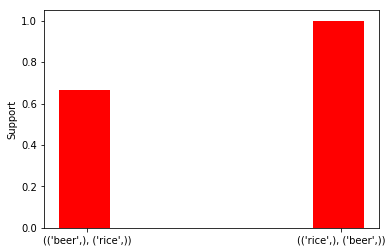

In [3]:
# Display in graph and plots
import numpy as np
import matplotlib.pyplot as plt

N = rules
names,values = zip(*N)
ind = np.arange(len(N))  # the x locations for the groups
width = 0.20      # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, values, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Support')
ax.set_xticks(ind+width/20)
ax.set_xticklabels(names)

plt.show()

#Reference
#https://matplotlib.org/examples/api/barchart_demo.html

The above bar graph shows the rules generated by running the algorithm with the support. 

Bibiography

https://www.analyticsvidhya.com/blog/2014/08/effective-cross-selling-market-basket-analysis/

https://matplotlib.org/examples/api/barchart_demo.html

https://github.com/asaini/Apriori

https://github.com/marshallshen/nyc_restaurants_inspection